# 08 - Billboard + Lyrics

In [59]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns

from gensim.models import Word2Vec
from matplotlib import rcParams
from matplotlib.patches import Rectangle
from scipy.stats import relfreq
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from wordcloud import WordCloud

#sns.set(context='poster', style='white')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'arial'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.filterwarnings('ignore')

## Load data

In [60]:
df = pd.read_csv('../data/billboard-lyrics-spotify.csv')
df.sample(3)

artist_all  artist_base  rank              song  year  \
2835                   rick astley  rick astley    44  together forever  1988   
2597                    mr. mister   mr. mister     5      broken wings  1986   
3651  do or die  featuring  twista    do or die    91           po pimp  1996   

     artist_featured        song_clean artist_clean  \
2835             NaN  together forever  rick astley   
2597             NaN      broken wings    mr mister   
3651          twista           po pimp    do or die   

                                                 lyrics  acousticness  \
2835  if theres anything you need all you have to do...        0.0417   
2597   baby dont understand why we cant just hold on...        0.1340   
3651   do you wanna ride in the backseat of a caddy ...        0.0623   

        ...      speechiness    tempo  time_signature  valence  duration_min  \
2835    ...           0.0518  115.091             4.0    0.903      3.416217   
2597    ...           0.0357   99.162             4.0    0.443      5.732217   
3651    ...           0.2720  142.075             4.0    0.649      3.913783   

      num_words  words_per_sec  num_uniq_words  decade uniq_ratio  
2835      175.0       0.853771            82.0    1980   2.134146  
2597      272.0       0.790852            77.0    1980   3.532468  
3651      740.0       3.151256           350.0    1990   2.114286  

[3 rows x 30 columns]

In [61]:
df_nonnull = df[df['lyrics'].notnull()]
lyrics = df_nonnull['lyrics']

## Verbosity over time

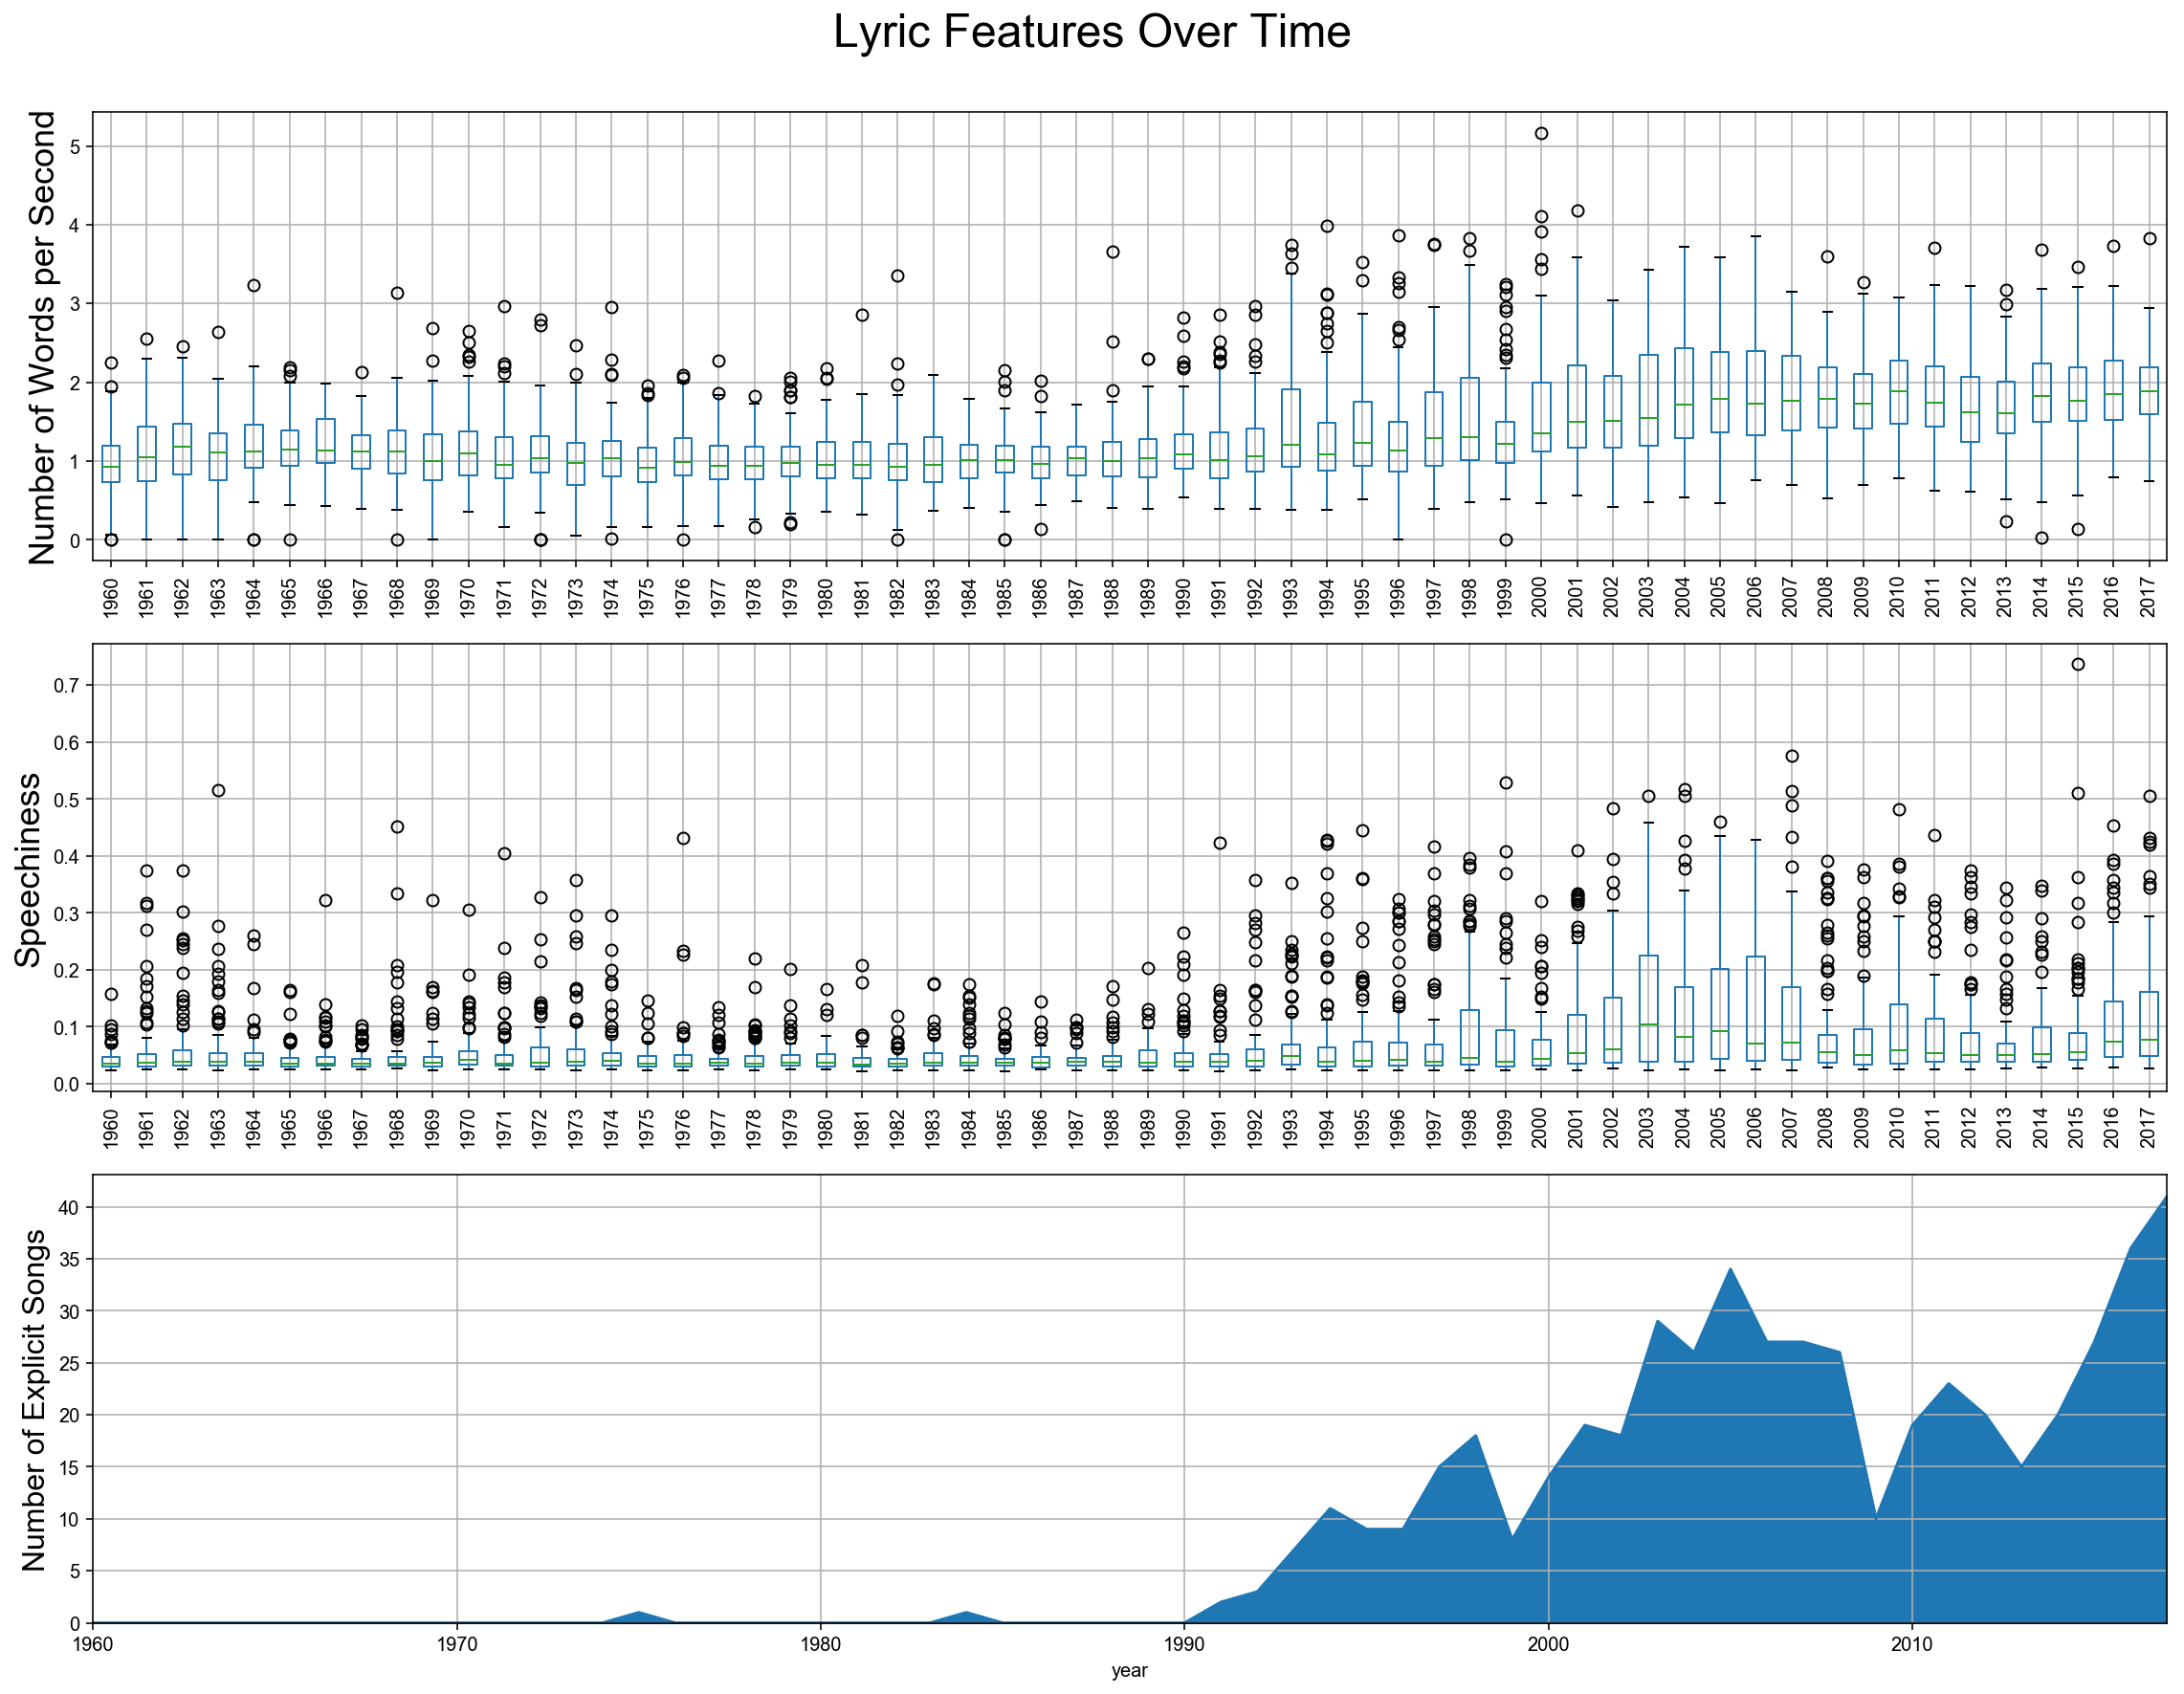

In [18]:
# make subplot axes
verbal_features = ['words_per_sec', 'speechiness']
ylabels = ['Number of Words per Second', 'Speechiness',
           'Number of Explicit Songs']
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# make time series boxplots
for ax, verbal_feature, ylabel in zip(axes, verbal_features, ylabels):
    df[['year',verbal_feature]].boxplot(by='year', rot = 90, ax=ax)
    ax.set(title='', xlabel='')
    ax.set_ylabel(ylabel, fontsize=18)
axes[2].set(xlabel='Year')

# make time series line plot
df_nonnull.groupby('year')['explicit'].sum().plot.area(ax=axes[2], grid=True)
axes[2].set_ylabel('Number of Explicit Songs', fontsize=16)

# suppress pandas boxplot title
plt.suptitle('Lyric Features Over Time', fontsize=24, y=1.02)
plt.tight_layout()

## Most decade specific words

In [63]:
import seaborn as sns
sns.set(context='poster', style='white')

def ngram_wordclouds(n=1, min_df=50):
    # make features and targets
    X = lyrics.copy()
    y = df_nonnull['decade']
    
    # make and fit Naive Bayes model
    stop_words = list(ENGLISH_STOP_WORDS)
    stop_words.extend(['shes', 'yes', 'didnt'])
    pipe = Pipeline([('count', CountVectorizer(min_df=min_df, binary=True,
                                    ngram_range=(n,n), stop_words=stop_words)),
                     ('bnb', BernoulliNB(binarize=0))])
    pipe.fit(X, y)

    # calculate class conditional feature probabilities and ...
    # unconditioned feature probabilities.
    feature_counts = pipe.named_steps.count.transform(lyrics).toarray().sum(axis=0)
    class_feature_counts = pipe.named_steps.bnb.feature_count_
    con_feat_probs = class_feature_counts / class_feature_counts.sum(axis=1).reshape(-1, 1)
    unc_feat_probs = feature_counts / feature_counts.sum()
    
    # conditional probability / unconditional probability = lift
    lift = con_feat_probs / unc_feat_probs + 1e-10
    
    # make subplot axes
    fig, axes = plt.subplots(2, 3, figsize=(16,10))
    axes = axes.ravel()

    colormaps = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'PuRd']
    vocab = pipe.named_steps.count.get_feature_names()
    for i, decade in enumerate(range(1960, 2020, 10)):
        # make word-weight dictionary
        color_func = colormap_size_func(colormaps[i], 300)
        feature = lift[i,:]
        dictionary = dict(zip(vocab, feature))
        
        # make word cloud
        wordcloud = WordCloud(background_color='white', height=1200,
                              min_font_size=5, width=1400, color_func=color_func,
                              max_words=len(X_artists), relative_scaling=0.5,
                              max_font_size=300)
        wordcloud = wordcloud.generate_from_frequencies(dictionary)
        
        # display word cloud
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set(title='Most {}s {}-grams'.format(decade, n))

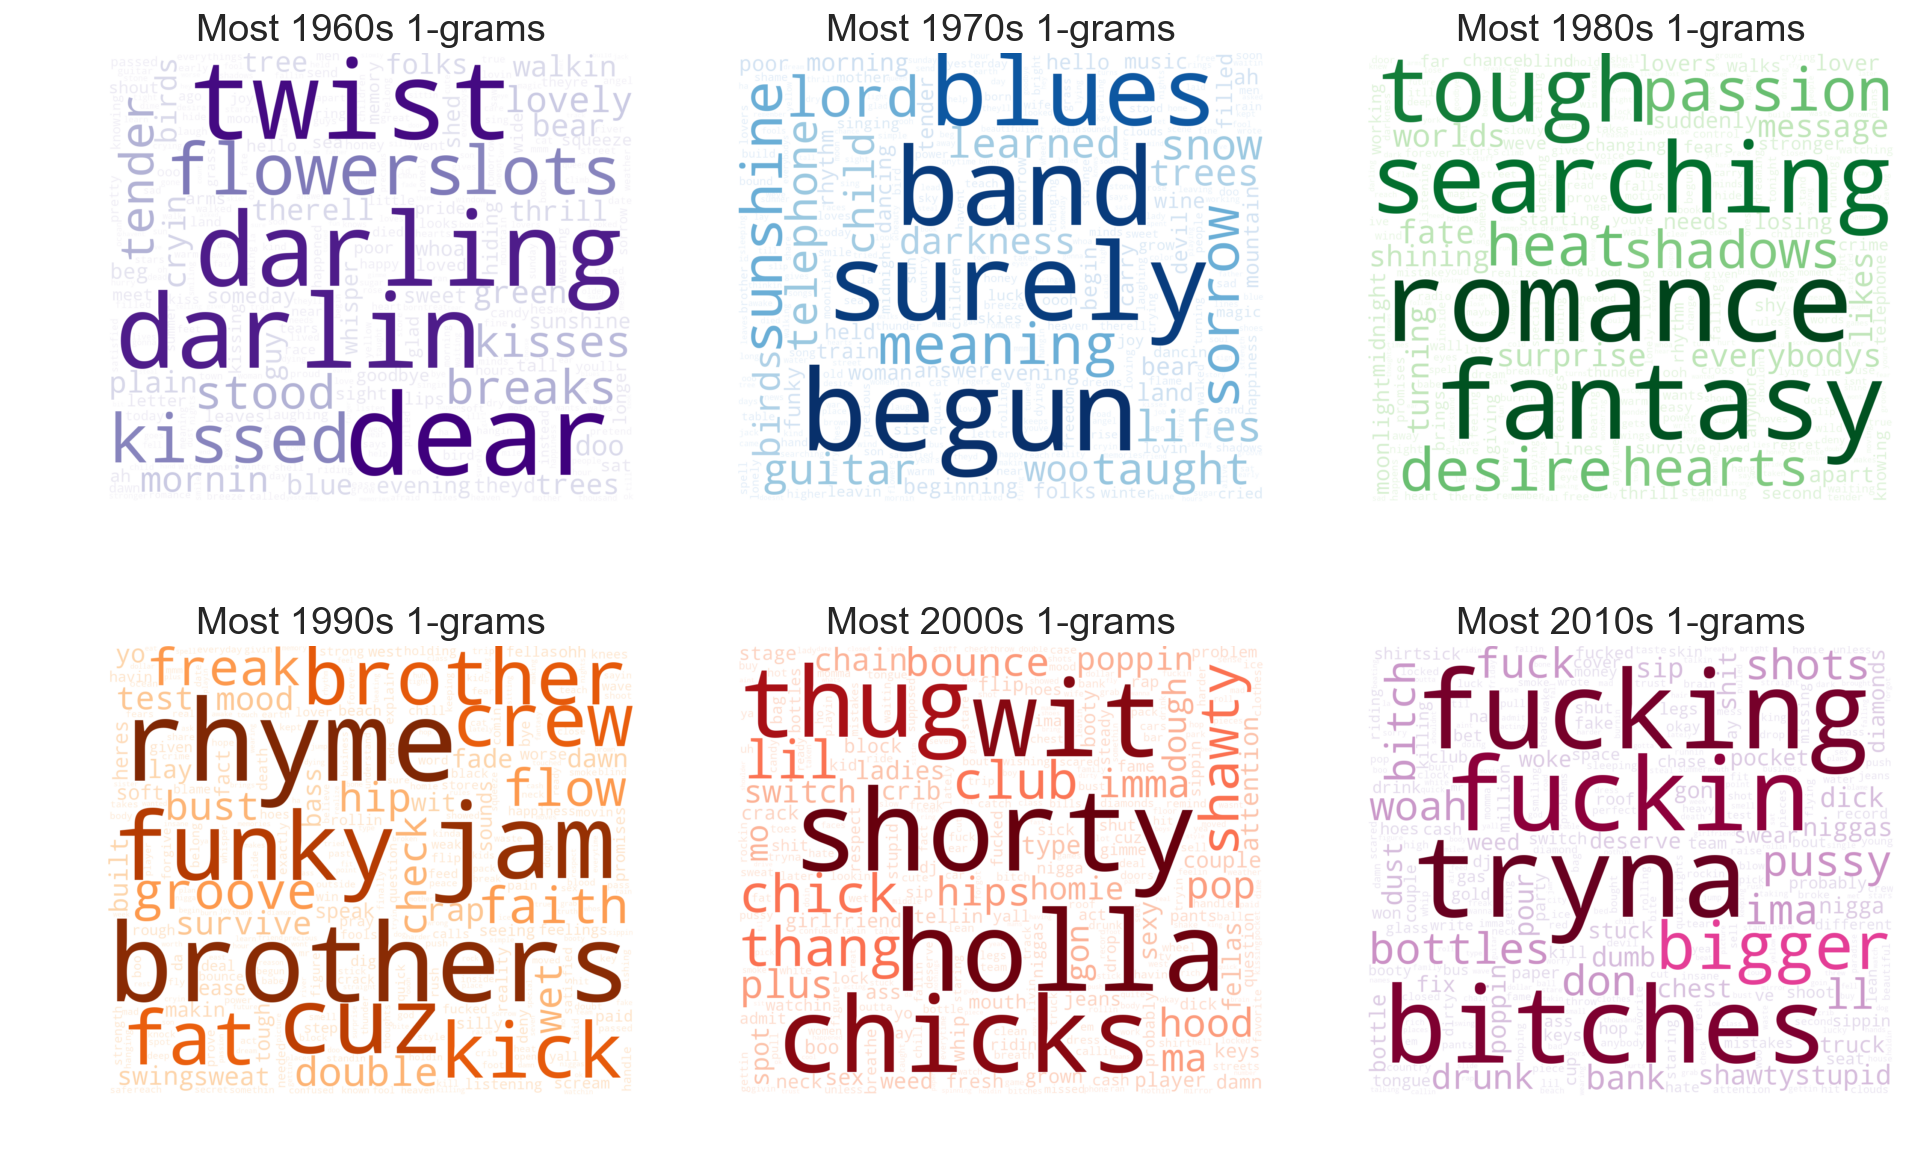

In [64]:
ngram_wordclouds()

## Most decade specific n-grams

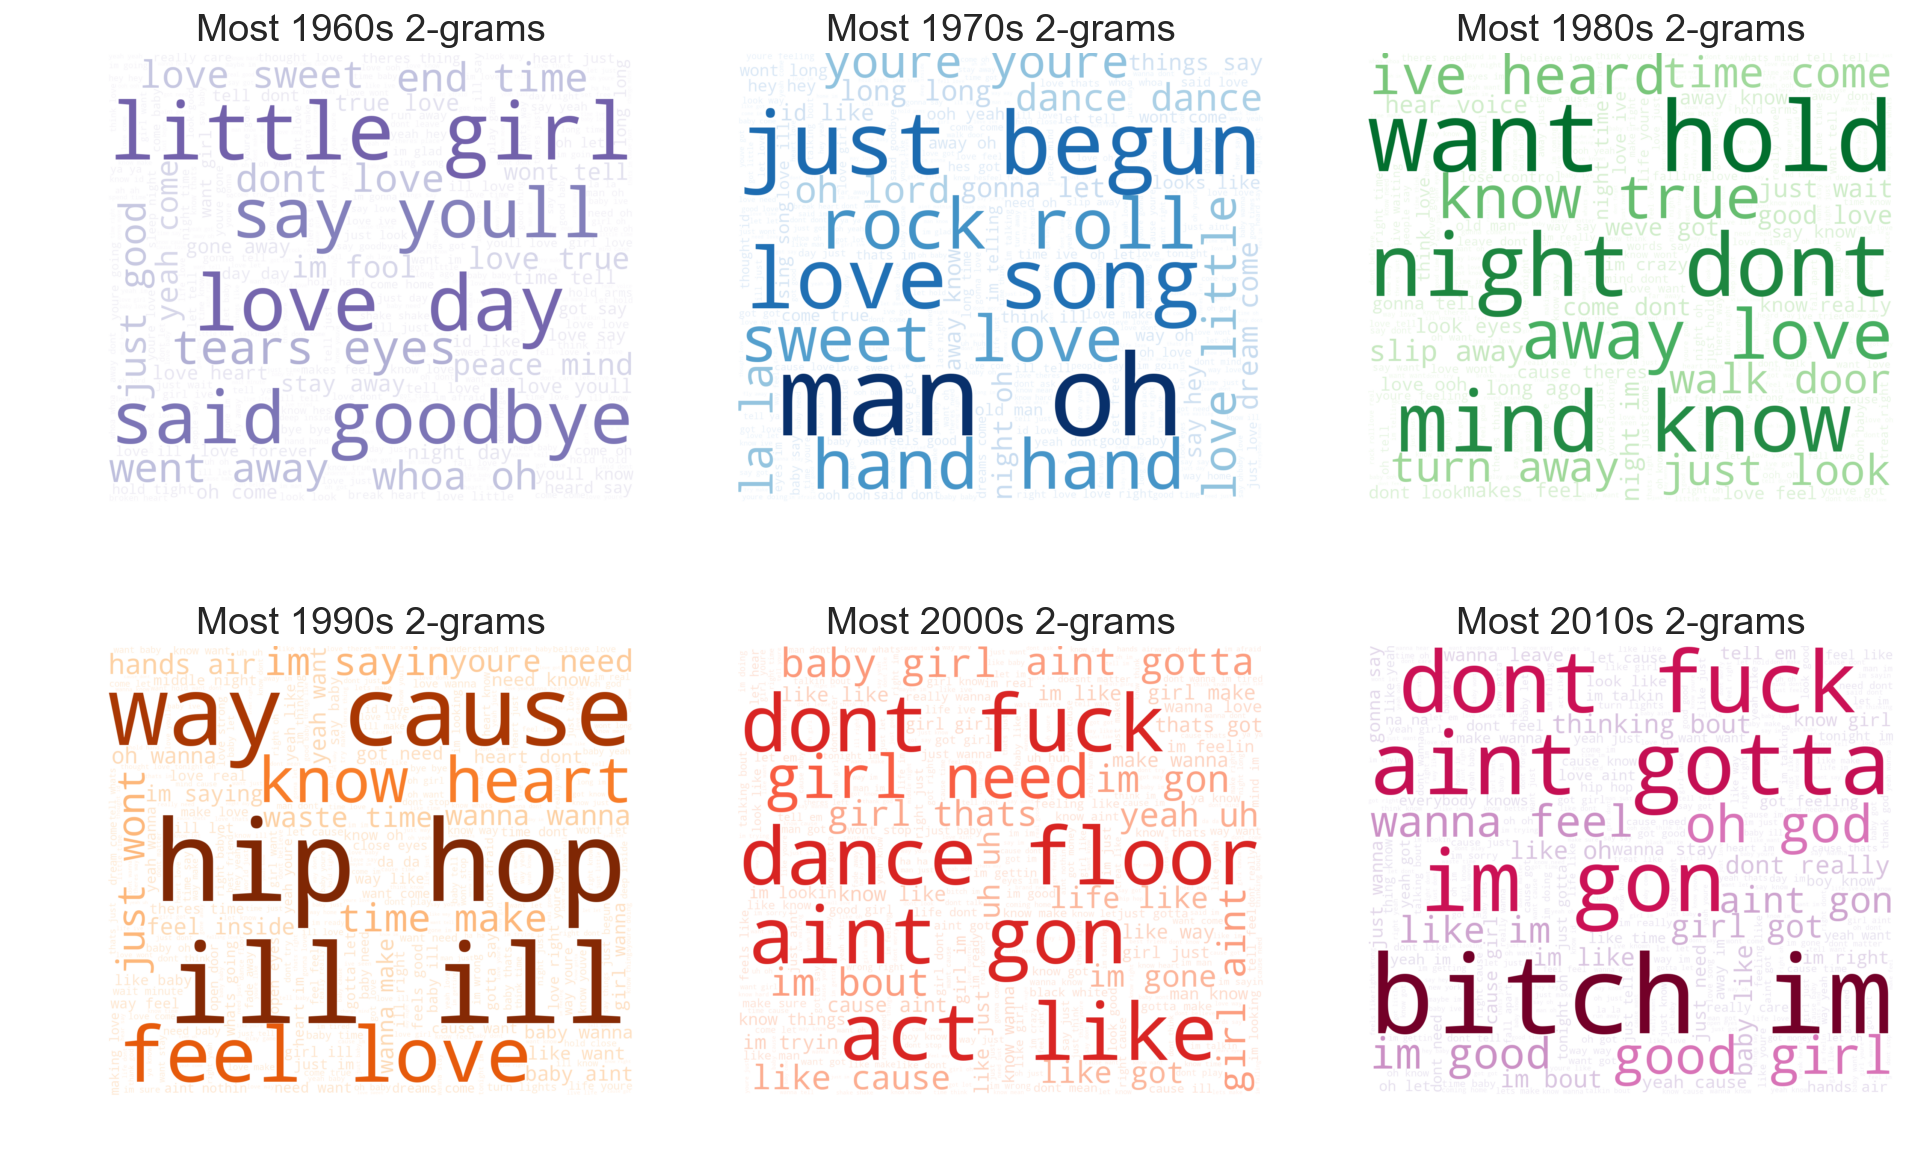

In [65]:
ngram_wordclouds(2, 30)

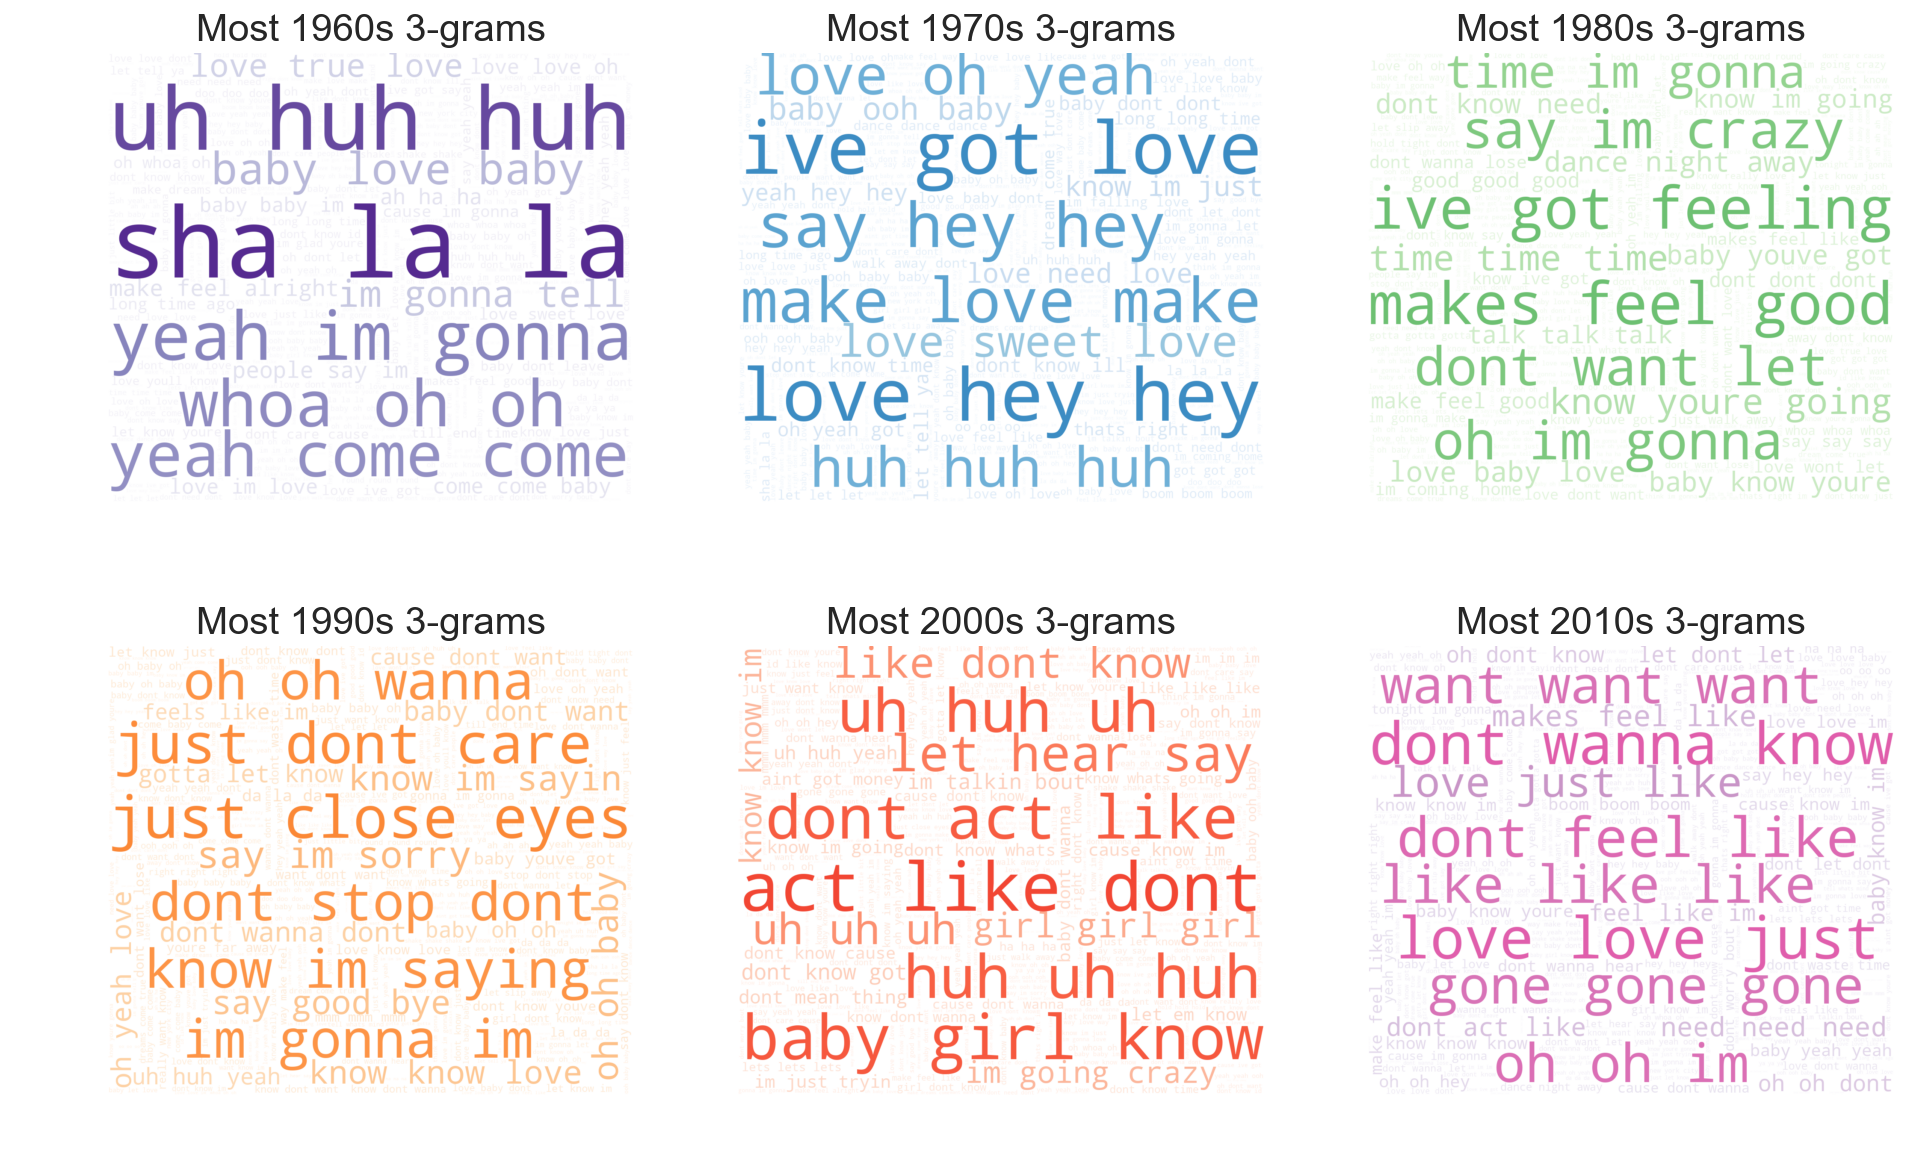

In [66]:
ngram_wordclouds(3, 10)

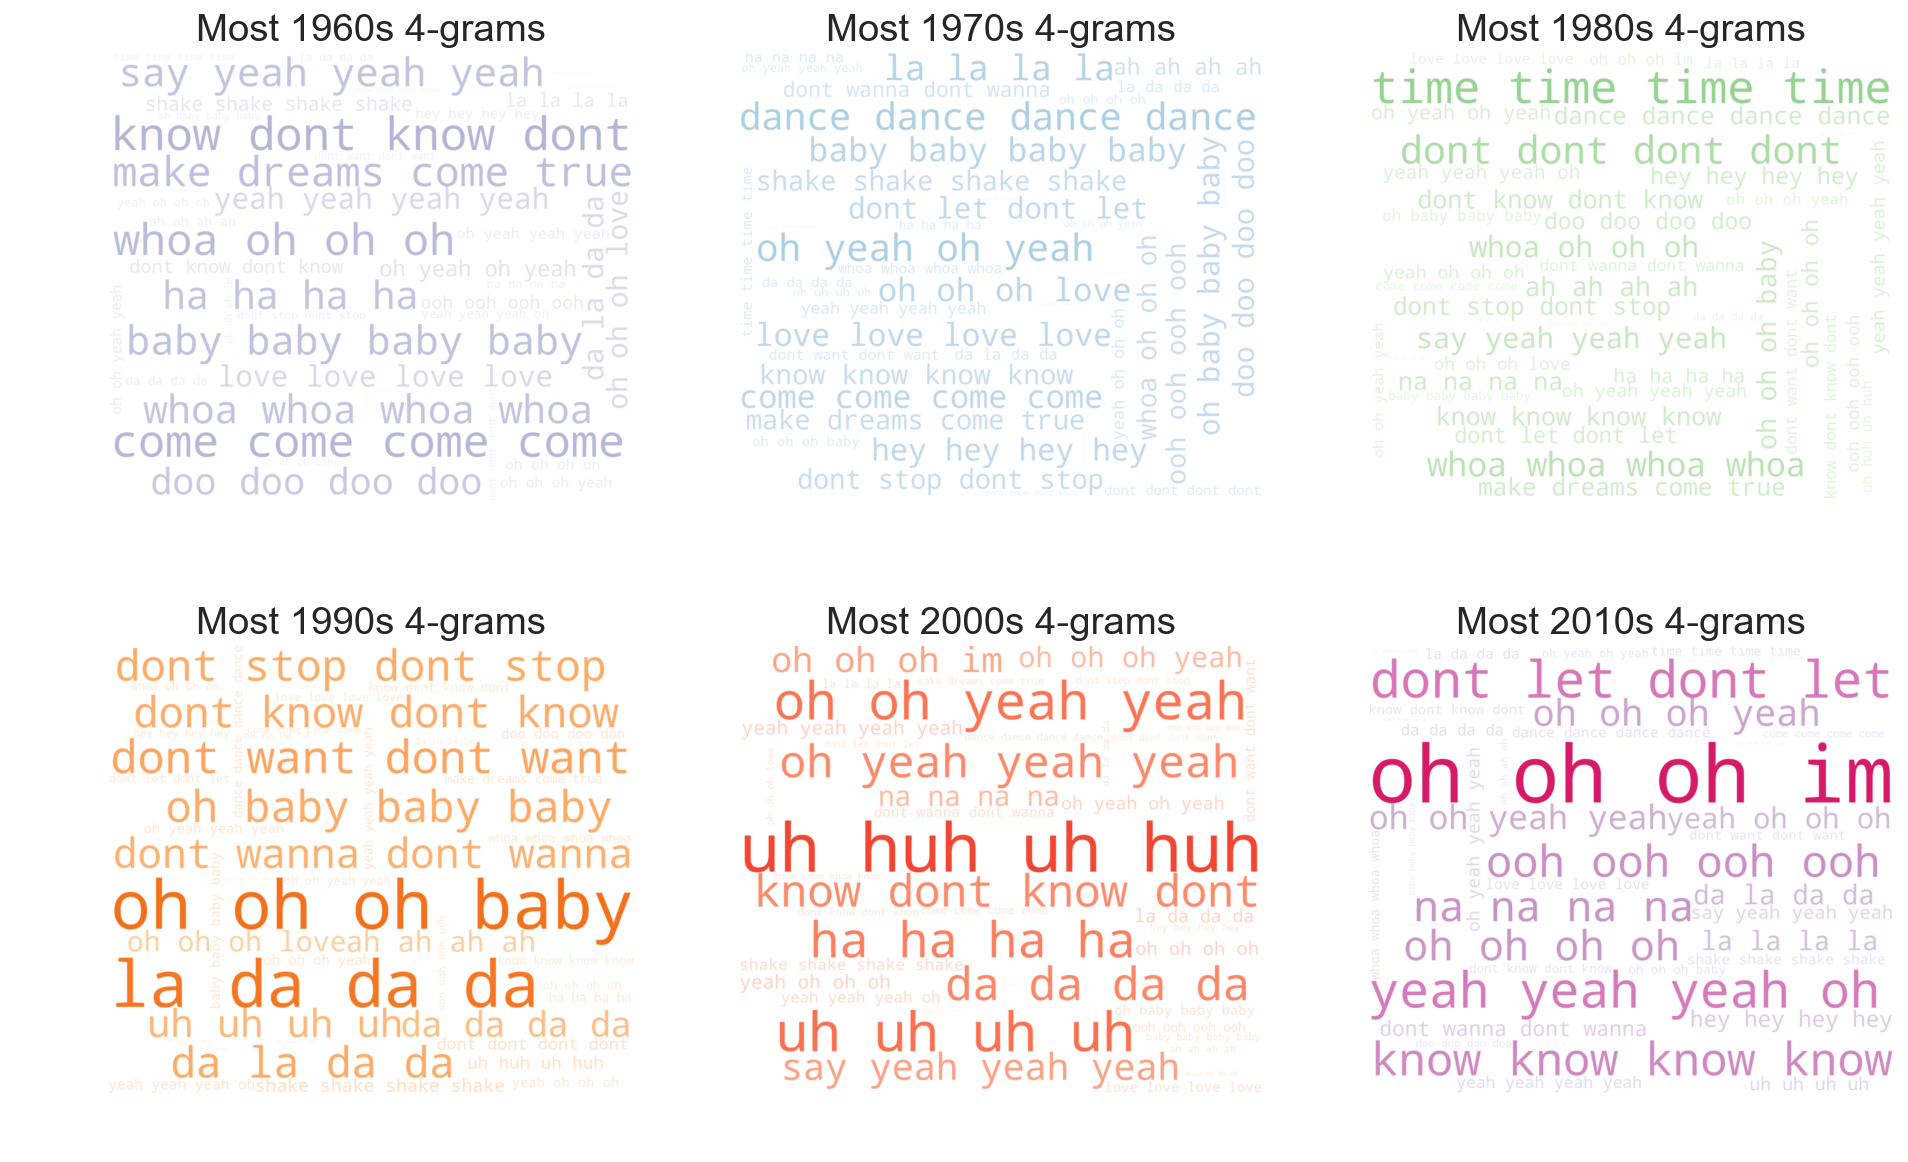

In [67]:
ngram_wordclouds(4, 10)

## Word frequencies over time

In [68]:
# convert each row into a dataframe where each row is a word instead of song
def row_to_df(x):
    if not isinstance(x['lyrics'], str):
        return None
    else:
        nonlyrics = x.drop('lyrics')
        lyrics = pd.Series(x.lyrics.split()).value_counts()
        lyrics = pd.DataFrame(lyrics).reset_index()
        lyrics.columns = ['word', 'count']
        lyrics['dummy'] = 1
        nonlyrics['dummy'] = 1
        nonlyrics = pd.DataFrame(nonlyrics).T
        return pd.merge(nonlyrics, lyrics, how='right', on='dummy')

# concatenates all word-based dataframes into a single word-based dataframe
def tidy_df(df):
    df_list = list()
    for index, row in df.iterrows():
        song_df = row_to_df(row)
        df_list.append(song_df)
    return pd.concat(df_list, axis=0)

In [69]:
df_tidy = tidy_df(df_nonnull)

# make list of words that appear in at least 10 unique songs
songs_per_word = df_tidy.groupby('word')['song'].agg(pd.Series.nunique)
songs_per_word = songs_per_word[songs_per_word >= 10]
words_to_keep = list(songs_per_word.index)

# keep only words that appear in at least 10 unique songs and their ...
# ...corresponding years of appearance
mask = df_tidy['word'].apply(lambda x: x in words_to_keep)
df_tidy = df_tidy.loc[mask,:][['word', 'year', 'count']]

# calculate frequencies of surviving words
words_freq = df_tidy.groupby(['year','word'])['count'].sum()
wf2 = words_freq.reset_index()

In [80]:
def word_time_series(words, colors):
    plt.figure(figsize=(16,5))
    ax = plt.axes()
    words = words
    colors = colors
    for word, color in zip(words, colors):  
        wf2[wf2['word']==word].plot.line(
            x='year', y='count', ax=ax, label=word, color=color, linewidth=2)
    ax.grid(True)
    ax.set(ylabel='Frequency', xlabel='Year', title='Word Usage Over Time')

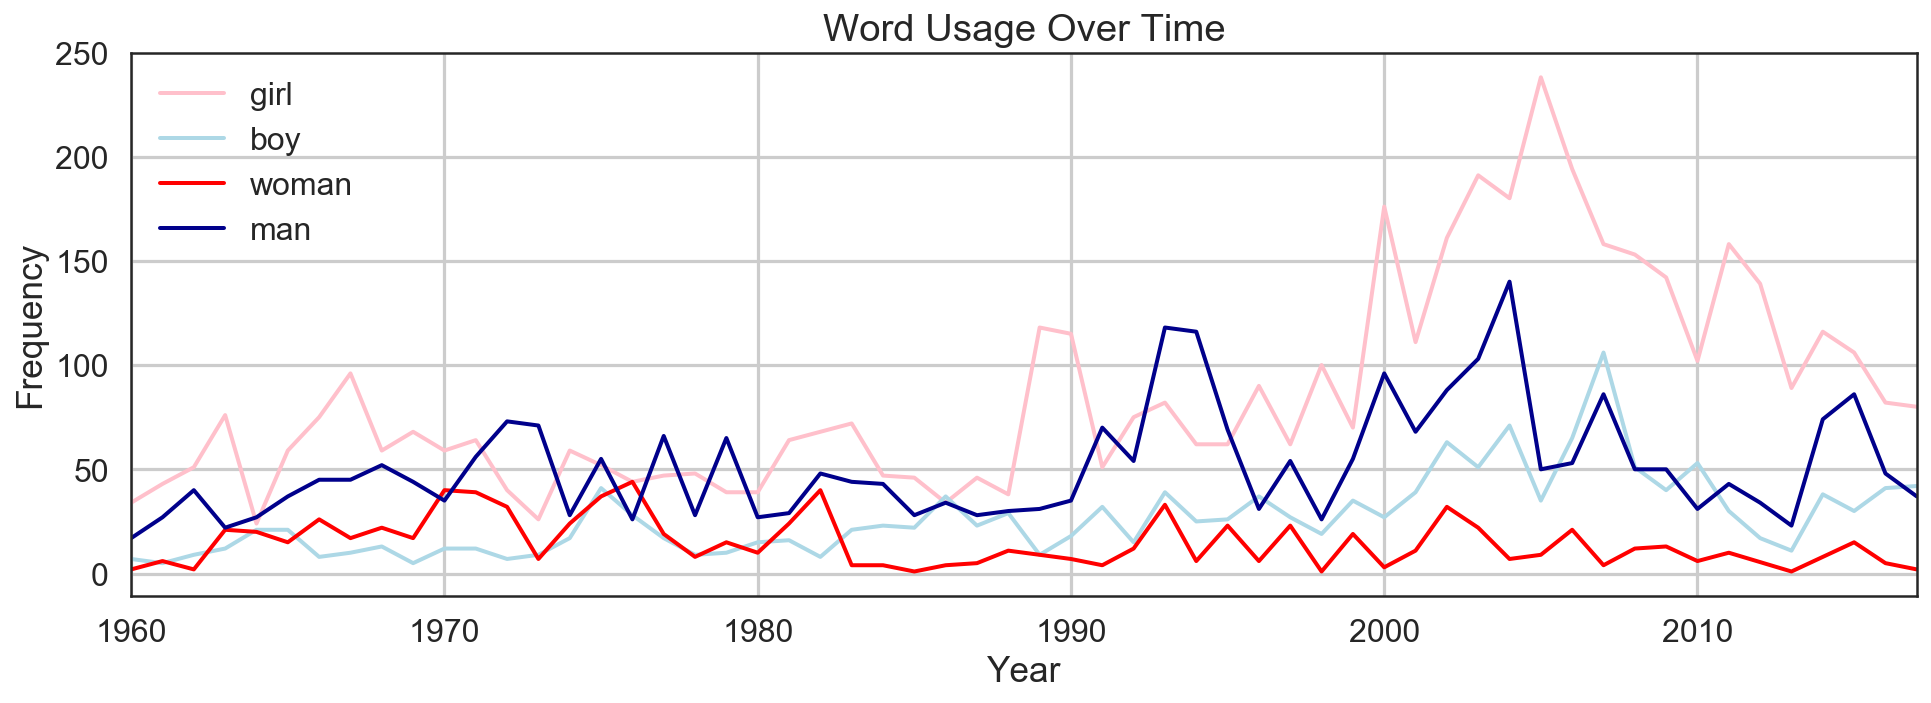

In [81]:
word_time_series(words=['girl', 'boy', 'woman', 'man'],
                 colors = ['pink', 'lightblue', 'red', 'darkblue'])

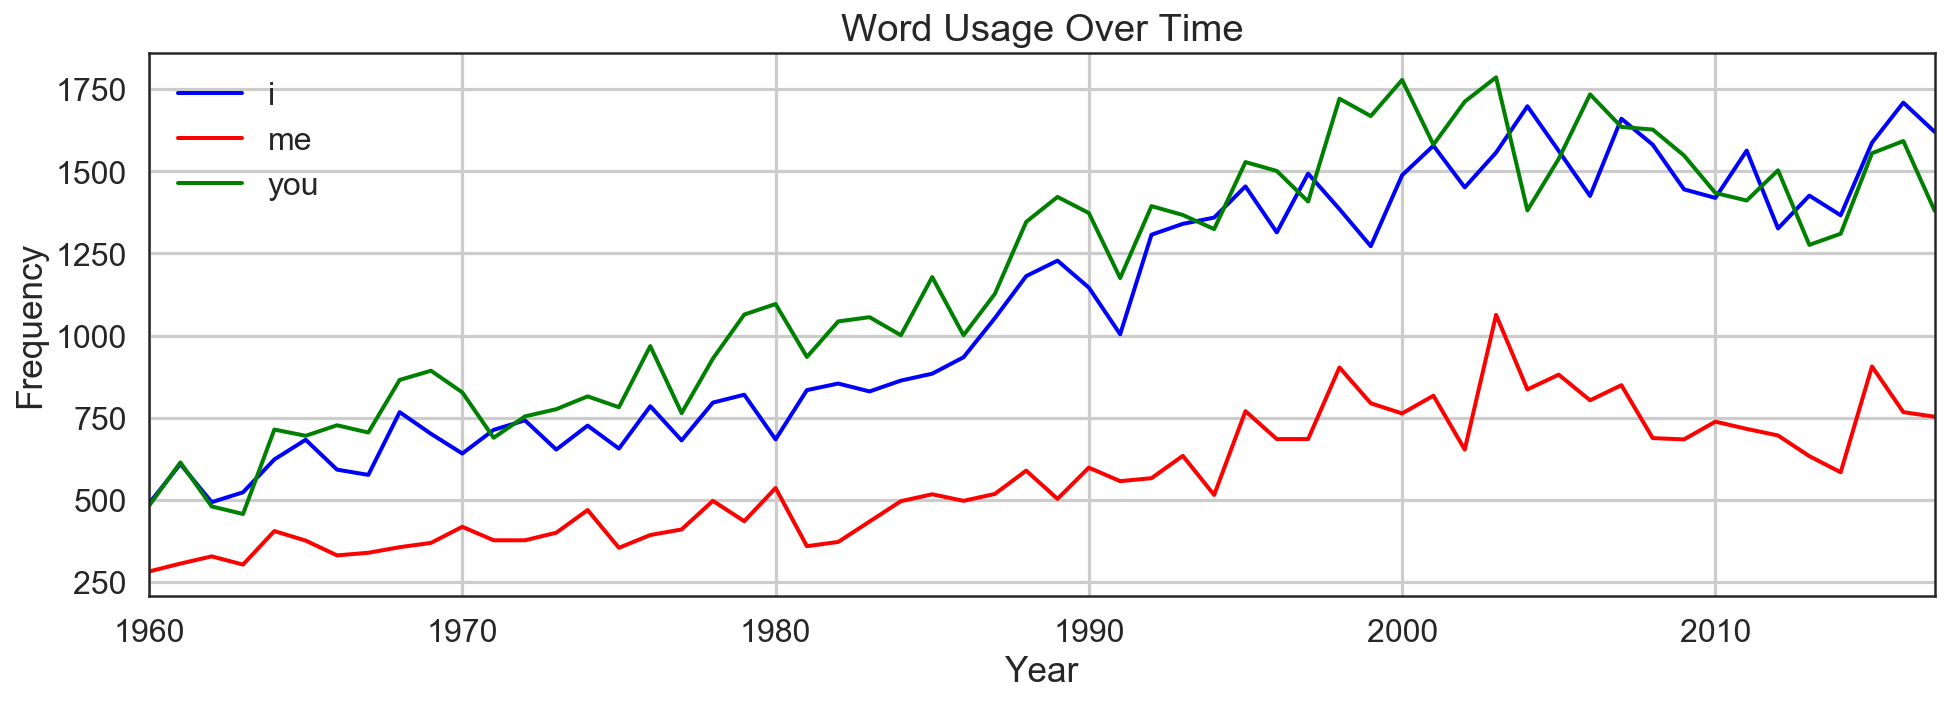

In [82]:
word_time_series(words=['i', 'me', 'you'],
                 colors=['blue', 'red', 'green'])

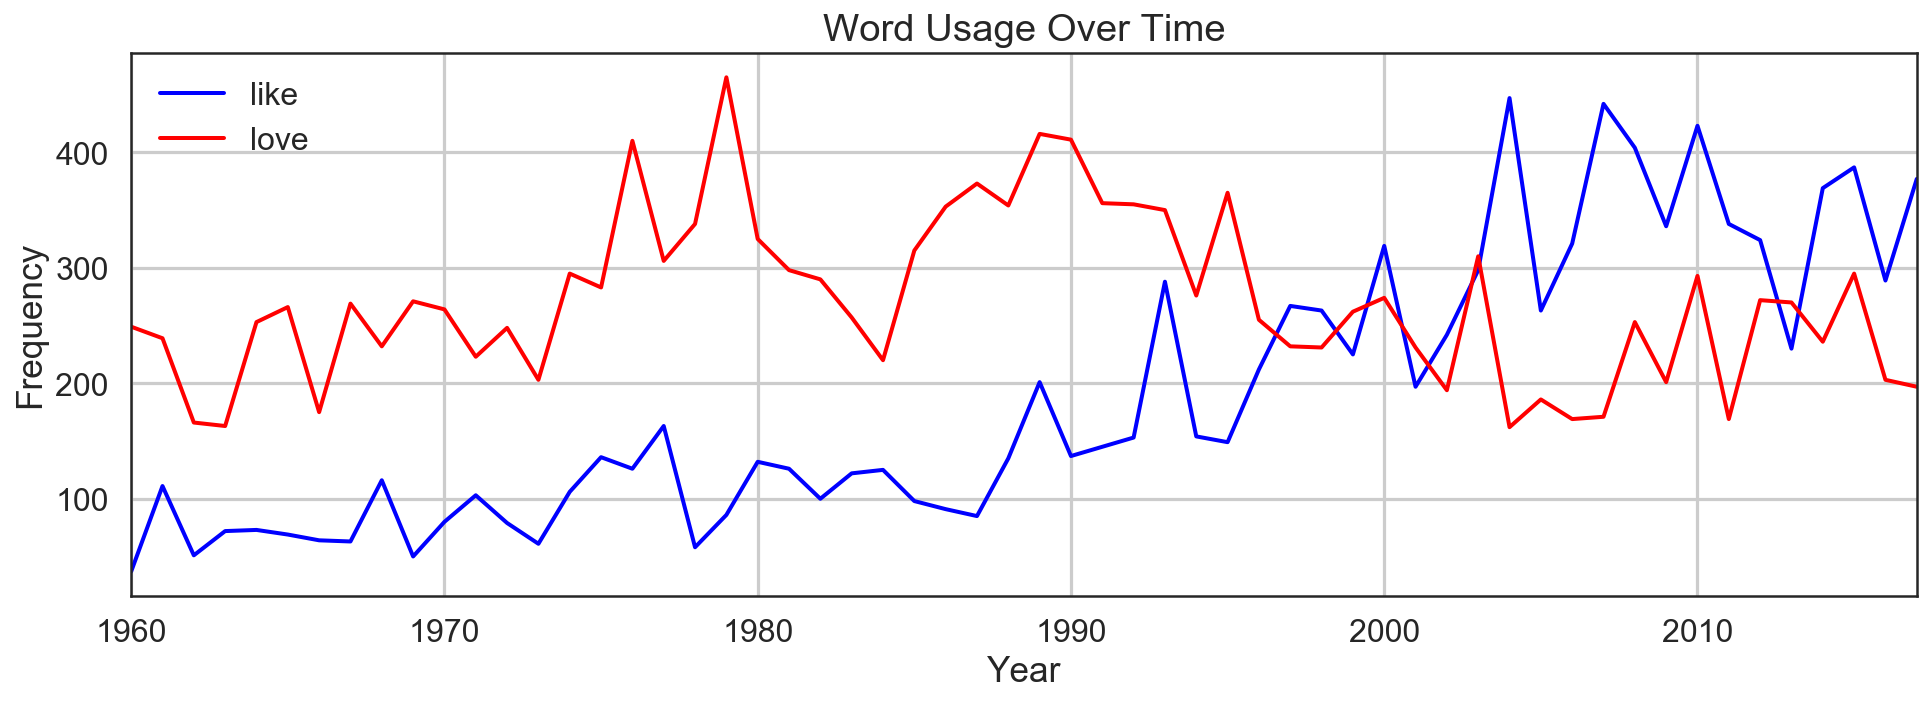

In [83]:
word_time_series(words=['like', 'love'],
                 colors = ['blue', 'red'])

## Latent space embeddings

In [519]:
df_nonnull = df[df['lyrics'].notnull()]
df_nonnull = df_nonnull.drop_duplicates(subset=['artist_clean', 'song_clean'], keep='first')

lyrics = df_nonnull['lyrics']
top_artists = df_nonnull.groupby('artist_clean')['song']\
                      .count()\
                      .sort_values(ascending=False)\
                      .index

X_entity_dfs = list()
count = CountVectorizer()
X_lyrics = count.fit_transform(lyrics)
X_lyrics = pd.DataFrame(X_lyrics.todense(), columns=count.get_feature_names())
X_songs = X_lyrics.set_index(df_nonnull['song'])
X_songs.index = [str('song_') + val for val in X_songs.index]
X_entity_dfs.append(X_songs)
X_songs_cp = X_songs.copy(deep=True)

artists = df_nonnull['artist_clean']
artists.index = X_songs_cp.index
X_songs_cp['artist_clean'] = artists
X_artists = X_songs_cp.groupby('artist_clean').mean()
X_artists = X_artists.reindex(top_artists).iloc[:20,:]
X_artists.index = [str('artist_') + val for val in X_artists.index]
X_entity_dfs.append(X_artists)

explicit = df_nonnull['explicit']
explicit.index = X_songs_cp.index
X_songs_cp['explicit'] = explicit
X_explicit = X_songs_cp.groupby('explicit').mean()
X_explicit.index = ['explicit_0', 'explicit_1']
X_entity_dfs.append(X_explicit)

decade = df_nonnull['decade']
decade.index = X_songs_cp.index
X_songs_cp['decade'] = decade
X_decade = X_songs_cp.groupby('decade').mean()
X_decade.index = ['decade_' + str(x) for x in range(1960, 2020, 10)]
X_entity_dfs.append(X_decade)

mode = df_nonnull['mode']
mode.index = X_songs_cp.index
X_songs_cp['mode'] = mode
X_mode = X_songs_cp.groupby('mode').mean()
X_mode.index = ['mode_0', 'mode_1']
X_entity_dfs.append(X_mode)

entities_index = list()
for X_entity_df in X_entity_dfs:
    entities_index.extend(list(X_entity_df.index))

X_entities = pd.concat(X_entity_dfs, axis='rows')
X_entities.index = entities_index

In [524]:
X_drop = X_entities.drop(['explicit', 'mode', 'decade'], axis='columns')

lda = LatentDirichletAllocation(n_components=10)
X_lda = lda.fit_transform(X_drop)

tsne = TSNE(n_components=2, metric='cosine', perplexity=75)
X_tsne = tsne.fit_transform(X_lda)

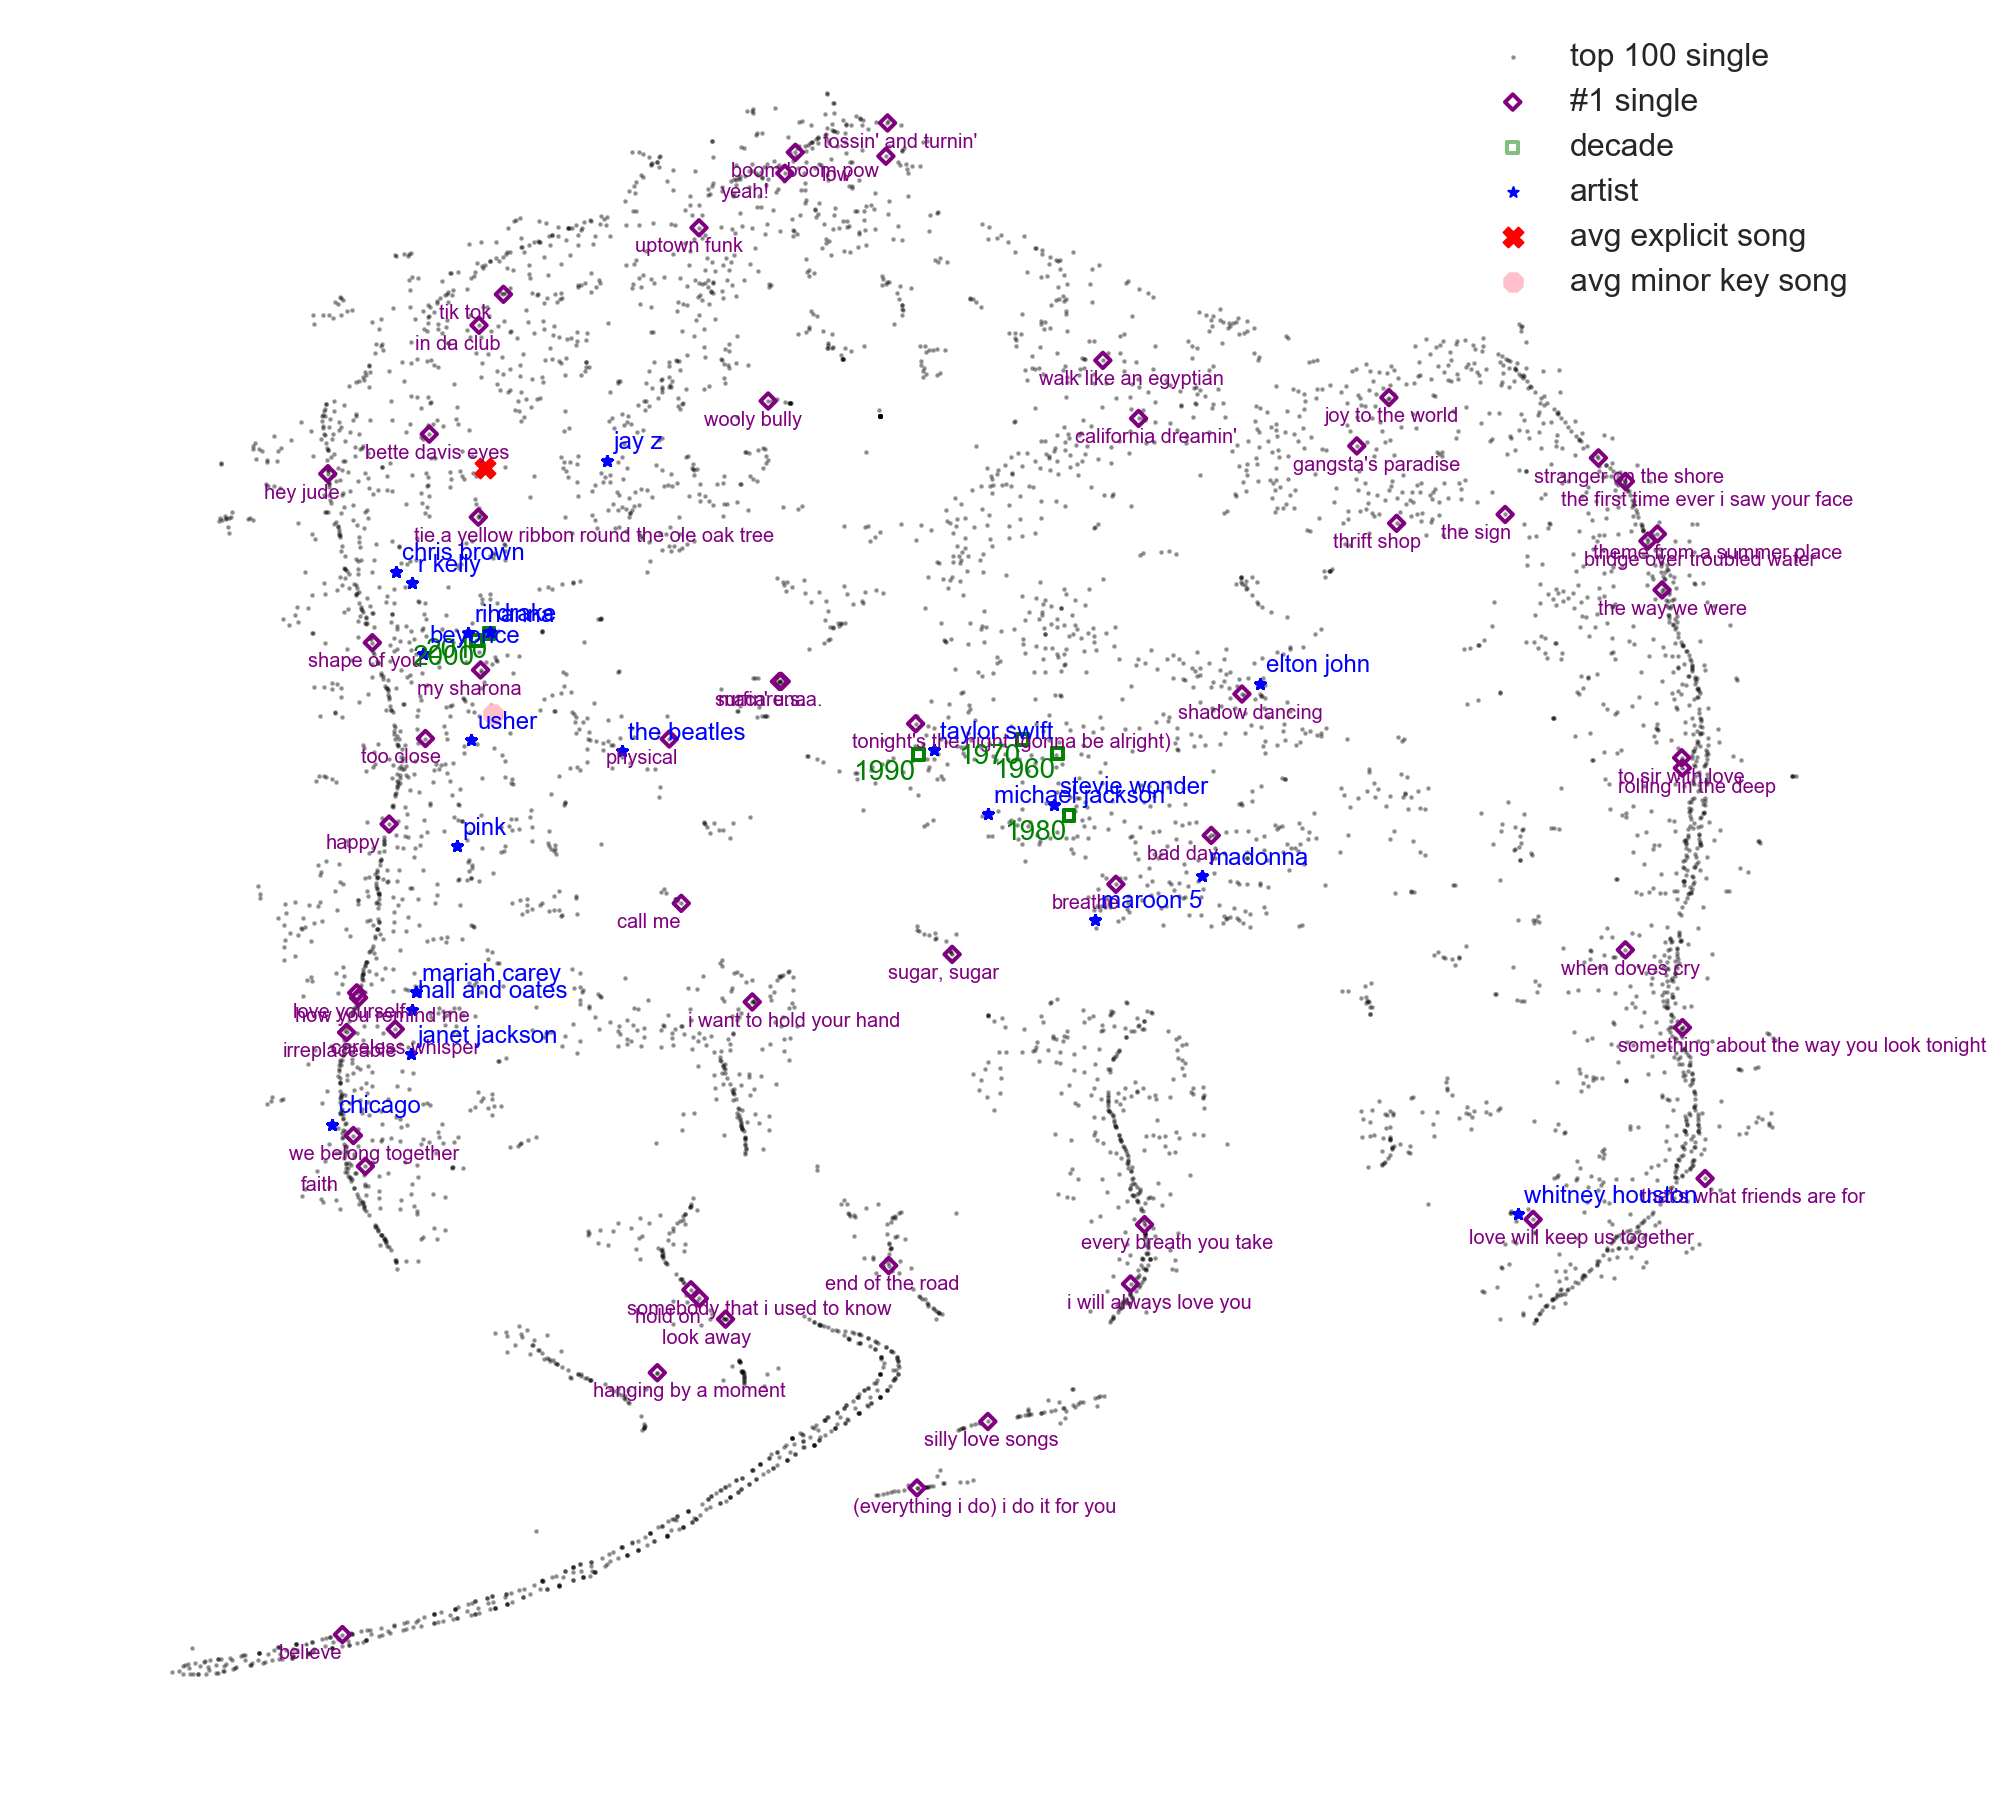

In [536]:
plt.figure(figsize=(16,16))
ax = plt.gca()

song_mask = X_entities.index.str.startswith('song_')
X_tsne_songs = X_tsne[song_mask,:]
ax.scatter(X_tsne_songs[:,0], X_tsne_songs[:,1], s=2, color='black', alpha=0.3,
           label='top 100 single', edgecolor='black', linewidth=1)

top_single_mask = df_nonnull['rank'] == 1
top_singles = df_nonnull.loc[top_single_mask, :]['song'].values
X_tsne_top = X_tsne[song_mask,:][top_single_mask,:]
for i in range(X_tsne_top.shape[0]):
    label = None
    if i == len(X_tsne_top) - 1:
        label = '#1 single'
    ax.annotate(top_singles[i], xy=X_tsne_top[i,:], color='purple',
                textcoords='offset points', xytext=(-32,-12), fontsize=10)
    ax.scatter(X_tsne_top[i,0], X_tsne_top[i,1], marker='D', color='None',
               linewidth=2, edgecolor='purple', s=30, label=label)

decade_mask = X_entities.index.str.startswith('decade_')
X_tsne_decade = X_tsne[decade_mask,:]
for i in range(X_tsne_decade.shape[0]):
    decade = X_entities.iloc[decade_mask,:].index[i][7:]
    label = None
    if decade == '2010':
        label = 'decade'
    ax.annotate(decade, xy=X_tsne_decade[i,:], color='green',
                textcoords='offset points', xytext=(-32,-12), fontsize=14)
    ax.scatter(X_tsne_decade[:,0], X_tsne_decade[:,1], marker='s', s=30,
               linewidth=2, alpha=0.5, edgecolor='green', color='None',
               label=label)
    
artists_mask = X_entities.index.str.startswith('artist_')
X_tsne_artists = X_tsne[artists_mask,:]
for i in range(X_tsne_artists.shape[0]):
    artist = X_artists.index[i][7:]
    label = None
    if i == len(X_tsne_artists) - 1:
        label = 'artist'
    ax.annotate(artist, xy=X_tsne_artists[i,:], color='blue',
                textcoords='offset points', xytext=(3,6), fontsize=12)
    ax.scatter(X_tsne_artists[:,0], X_tsne_artists[:,1], marker='*', s=30,
               linewidth=1, color='blue', label=label)
    
explicit_mask = X_entities.index == 'explicit_1'    
x,y = X_tsne[explicit_mask,:].squeeze()
ax.scatter(x, y, marker='X', s=100, linewidth=1, alpha=1, color='red',
           label='avg explicit song')

minor_mask = X_entities.index == 'mode_0'    
x,y = X_tsne[minor_mask,:].squeeze()
ax.scatter(x, y, marker='8', s=100, linewidth=1, alpha=1, color='pink',
           label='avg minor key song')

ax.legend()

#ax.set(xlim=(-35,35), ylim=(-100,100))
ax.axis('off');